## Q2 Solution

### Scattering of wavepacket in rectangular barrier potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate
from scipy import sparse

#### Rectangular barrier potential

In [2]:
def potential(x):
    V = np.zeros((x.shape))
    for i in range(len(x)):
        if x[i]>=-a and x[i]<=a:
            V[i] = V0
        else:
            V[i] = 0.0
    return V

#### Initial Conditions Setting

In [3]:
m     = 1                           # mass
hbar = 1                            # hbar = 1.0545718176461565e-34

dx    = 0.02                        # spatial separation
x     = np.arange(-30, 30, dx)      # spatial grid points
x0 = -5                             # center of initial gaussian wave-packet peaked at x=x0 in position space

k0    = 0.5                         # center of initial gaussian wave-packet peaked at k=k0 in k-space
sigma = 1.0                         # width of initial gaussian wave-packet in k-space

A = sigma/np.sqrt(np.pi)            # Normalization constant

# Initial Wavefunction in position-space for given 'k'
def psi(k):
    return np.sqrt(A)* np.exp(-sigma**2 * (x-x0)**2 / 2) * np.exp(1j * k * x)
psi0 = psi(k0)

# Rectangular barrier potential V(x)
a = 1.0                             # width of barrier
V0 = 1.0                            # Parameter controlling height of step potential
V = potential(x)

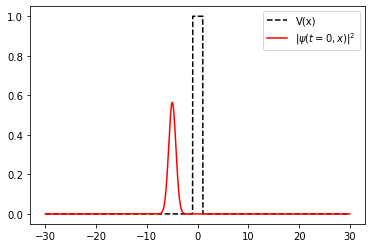

Total Probability:  1.0000000000000215


In [4]:
# Make a plot of psi0 and V 
plt.figure(figsize=(6, 4))
plt.plot(x, V, "k--", label=r"V(x)")
plt.plot(x, np.abs(psi0)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.legend(loc=1, fontsize=10)
plt.show()
print("Total Probability: ", np.sum(np.abs(psi0)**2)*dx)

#### Solving Schrodinger equation 
Original 1-D Schrodinger equation: $$-\frac{\hbar^2}{2m}\nabla^2\psi + V \psi = i\hbar\frac{\partial}{\partial t}\psi$$

In [5]:
# RHS of Schrodinger Equation
def psi_t(t, psi):
    return -1j * (- 0.5 * hbar / m * D2.dot(psi) + V / hbar * psi)

In [6]:
# Laplace Operator (Finite Difference) for numerical 2nd-order differentiation of psi wrt x
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2

#### Expectation value of energy for given $\psi ( x, t )$

$$ < E > = \int_{-\infty}^{\infty} \psi^{*} ( x, t ) \hat{H} \psi dx $$

where, $$ \hat{H} = -\frac{\hbar^2}{2m}\nabla^2 + V  $$

In [7]:
# Calculating expectation value of energy of wavepacket for given wavefunction
def expec_energy(psi):
    return np.sum(psi.conj().T * (- 0.5 * hbar**2 / m * D2.dot(psi) + V * psi))*dx

#### Transmission and reflection coefficient

$$ T = \lim_{t \to \infty} \int_a^{\infty} |\psi( x, t )|^2 dx $$

$$ R = \lim_{t \to \infty} \int_{-\infty}^{-a} |\psi( x, t )|^2 dx $$

In [8]:
a_minus_idx = np.where( x == x[x<=-a][0] )[0][0]
a_plus_idx = np.where( x == x[x>=a][0] )[0][0]
    
# Numerical transmission and reflection coefficient
def transrefcoeff_numeric(psi):
    psileft =  psi[0:a_minus_idx+1]
    psiright = psi[a_plus_idx:-1]
    R = np.sum(psileft.conj().T*psileft)*dx
    T = np.sum(psiright.conj().T*psiright)*dx
    return [R,T]

# Analytic transmission and reflection coefficient
def transrefcoeff_analyt(E):
    k = np.sqrt(2*m*E)/hbar
    if E > V0 :
        l = np.sqrt(2*m*(E-V0))/hbar
        T = 1/( 1 + ((k/l - l/k)**2)*((np.sin(2*l*a))**2)/4 )
        R = 1 - T
        return [R,T]
    if E == V0 :
        T = 1/( 1 + (k**2)*(a**2) )
        R = 1 - T
        return [R,T]
    if E < V0 :
        alpha = np.sqrt(2*m*(V0-E))/hbar
        T = 1/( 1 + ((k/alpha + alpha/k)**2)*((np.sinh(2*alpha*a))**2)/4 )
        R = 1 - T
        return [R,T]

In [9]:
kx_list = np.arange(0.1,4.5,0.05)
expec_energy_list = np.zeros((kx_list.shape))

for i in range(len(kx_list)):
    kx0   = kx_list[i]        
    expec_energy_list[i] = np.real(expec_energy(psi(kx0)))

In [10]:
t0 = 0.0     # initial time
tf = 10.0    # final time
dt = 0.005   # time interval 
t_eval = np.arange(t0, tf, dt)  # recorded time shots

# Numerical transmission and reflection coefficient
Txn_coeff_numeric = np.zeros((kx_list.shape))
Ref_coeff_numeric = np.zeros((kx_list.shape))

# Analytic transmission and reflection coefficient
Txn_coeff_analyt = np.zeros((kx_list.shape))
Ref_coeff_analyt = np.zeros((kx_list.shape))

for i in range(len(kx_list)):
    kx0   = kx_list[i]  
    sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi(kx0), t_eval = t_eval, method="RK23")
    # Take psi(x,t) solution at later time t = tf to calculate txn / ref coefficient
    [R1,T1] = transrefcoeff_numeric(sol.y[:,-1])
    Txn_coeff_numeric[i] = T1.real
    Ref_coeff_numeric[i] = R1.real
    
    E = expec_energy_list[i]
    [R2,T2] = transrefcoeff_analyt(E)
    Txn_coeff_analyt[i] = T2
    Ref_coeff_analyt[i] = R2

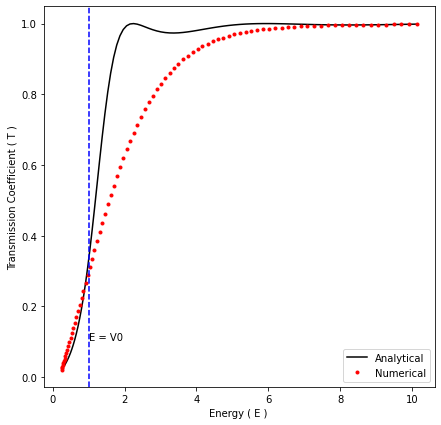

In [11]:
plt.figure(figsize=(7,7))
plt.plot(expec_energy_list,Txn_coeff_analyt, "k",label="Analytical")
plt.plot(expec_energy_list,Txn_coeff_numeric,".r",label="Numerical")
plt.axvline(x=V0, color='b', linestyle='--')
plt.text(V0, plt.ylim()[1]*0.1, 'E = V0', color='black', ha='left')
plt.xlabel('Energy ( E ) ')
plt.ylabel('Transmission Coefficient ( T )')
plt.legend()
plt.show()